# (PSL): Coding Assignment 3
CS598, Fall 2023

**Authors**:
*   Qi Zhou - qizhou8 - MCS-DS
*   Yogananth Mahalingam - ym24 - MCS-DS
*   Derek Zhang - derekz3 - MCS-DS

**Contributions**:

Qi, Yoga, and Derek worked on it independently, brainstormed together, and created the final version.

[Instructions](https://liangfgithub.github.io/Coding/Coding3.html#Submission_Requirements)

# Part 0: Setup

## Install Libraries

In [ ]:
!pip install scikit-fda scikit-misc &> /dev/null

## Load Data and Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skmisc.loess import loess
from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression

from numpy.linalg import inv
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def read_public_gdrive_file(file_id):
    url = 'https://drive.google.com/uc?id={}'.format(file_id)
    return pd.read_csv(url)

Coding3_Data = read_public_gdrive_file("1AIk_wJX6oxV3c24F2IwYmWxp3HwzLVI3")
Sales_Transactions_Dataset_Weekly = read_public_gdrive_file("15GF8-dg99pmpHhL8MgVckCSJFliOPLs4")
Coding3_dataH = read_public_gdrive_file("11_m1wTLR19plswkIYf0023HOudSVIA0d")

# Part I: Optimal Span for LOESS

In [ ]:
df = Coding3_Data
print(df.head())
print(df.shape)

          x         y
0  0.009496  2.692822
1  0.039996  0.566787
2  0.045770 -0.133373
3  0.113703 -2.696734
4  0.159046 -0.145285
(30, 2)


## LOO-CV/GCV Prediction Error

In [ ]:
def compute_loocv(residuals, trace):
    return np.mean((residuals/(1-trace))**2)

def compute_gcv(residuals, trace):
    avg_trace = np.repeat(np.mean(trace), len(trace))
    return np.mean((residuals/(1-avg_trace))**2)

def compute_pred_error(X, y, span):
    model = loess(df['x'], df['y'], span=span)
    model.fit()
    residuals = model.outputs.fitted_residuals
    trace = model.outputs.diagonal
    return {
        "loocv": compute_loocv(residuals, trace),
        "gcv": compute_gcv(residuals, trace),
    }

spans = np.arange(0.2, 0.9 + 0.05, 0.05)    # {0.20, 0.25, ..., 0.90}
X = df['x'].to_numpy()
y = df['y'].to_numpy()
pred_errors = []

for span in spans:
    pred_error = compute_pred_error(X, y, span)
    pred_errors.append({"span": span, **pred_error})
    print("span: {span: <10} loocv: {loocv: <25} gcv: {gcv: <25}".format(
        span=f'{span:.2f}',
        **pred_error
    ))

def get_optimal_spans(pred_errors: pd.DataFrame):
    optimal_spans = {}
    for computation in ['loocv', 'gcv']:
        condition = pred_errors[computation]==pred_errors[computation].min()
        optimal_span = round(pred_errors[condition]['span'].iloc[0], 2)
        optimal_spans[computation] = optimal_span
    return optimal_spans


pred_errors = pd.DataFrame(pred_errors)
optimal_spans = get_optimal_spans(pred_errors)
print("loocv optimal span: {}".format(optimal_spans["loocv"]))
print("gcv optimal span: {}".format(optimal_spans["gcv"]))

span: 0.20       loocv: 12.415910699869332        gcv: 2.1101618419429564       
span: 0.25       loocv: 2.2414734958901574        gcv: 1.489205632621718        
span: 0.30       loocv: 1.5029798111583716        gcv: 1.1901098446318241       
span: 0.35       loocv: 1.2591747084691483        gcv: 1.1744229564766884       
span: 0.40       loocv: 1.1903799279913378        gcv: 1.1025399038231012       
span: 0.45       loocv: 1.1568121230625679        gcv: 1.0625034645069502       
span: 0.50       loocv: 1.1256523403714556        gcv: 1.0418328786112798       
span: 0.55       loocv: 1.1796637523744389        gcv: 1.1188405514998314       
span: 0.60       loocv: 1.1794641625428166        gcv: 1.1192688072551895       
span: 0.65       loocv: 1.2509138273813027        gcv: 1.1805847769313835       
span: 0.70       loocv: 1.5535622642533482        gcv: 1.5190908128135598       
span: 0.75       loocv: 1.6361746170729459        gcv: 1.6274293455726159       
span: 0.80       loocv: 1.76

## Plot Fitted Curve(s)

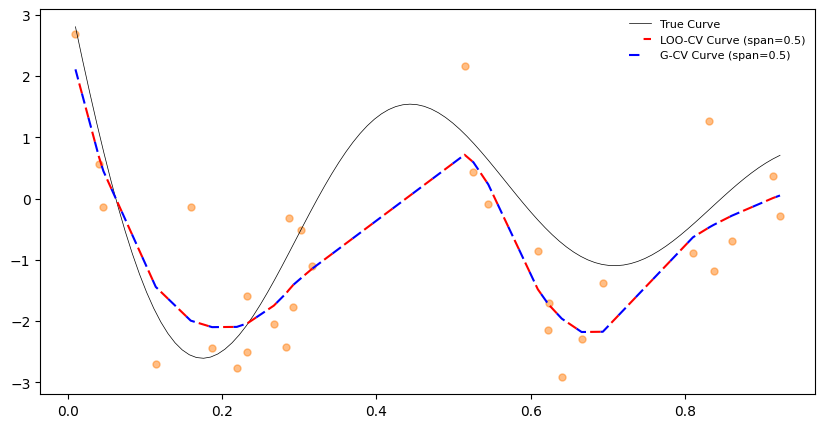

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(df['x'], df['y'], marker='.', s=100, alpha=0.5, c='tab:orange')

true_x = np.linspace(min(df['x']), max(df['x']), 100)
true_y = np.sin(12*(true_x+0.2))/(true_x+0.2)
plt.plot(true_x, true_y, c='black', linewidth=0.5, label='True Curve')

for computation, span in optimal_spans.items():

    model = loess(df['x'], df['y'], span=span)
    model.fit()
    pred = model.predict(df['x'])

    if computation == "loocv":
        plt.plot(df['x'], pred.values, linestyle=(5, (5, 7)), color='red', label=f'LOO-CV Curve (span={span})')
    if computation == "gcv":
        plt.plot(df['x'], pred.values, linestyle=(0, (5, 7)), color='blue', label=f'G-CV Curve (span={span})')

plt.legend(fontsize=8, markerscale=1.5, edgecolor='white')

# Part II: Clustering Time Series

In [ ]:
df = Sales_Transactions_Dataset_Weekly
df = df.iloc[:, 1:53]   # {W0, W1, ..., W51}

# Apply mean centering to each row
df = df.apply(lambda x: x-x.mean(), axis=1)

## Fitting NCS

In [ ]:
#@title Python ns()
# provided in Python_W5_RegressionSpline.ipynb
# https://campuswire.com/c/G06C55090/feed/286
# https://campuswire.com/c/G06C55090/feed/7

# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oright, :] = xr @ tt

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

In [ ]:
# fit all products using provided formula
# https://liangfgithub.github.io/Coding/Coding3.html#Task8

week_idx = np.arange(1, 52 + 1, 1)  # {1, 2, ... 52}
F = ns(week_idx, df=9)

X = df.to_numpy()
print(X.shape)

B = inv(np.dot(F.T, F)).dot(F.T).dot(X.T).T
print(B.shape)
print(B[0])

(811, 52)
(811, 9)
[ 3.97623613 -2.15466844 -0.87231507 -1.9512264  -0.2026932   2.49663618
 -5.15796219  0.6460706  -4.11650466]


## Clustering Matrix B

In [ ]:
def get_cluster(data, kmeans, label: int):
    cluster_idx = (kmeans.labels_ == label).astype(int)
    cluster_arrays = data[cluster_idx.astype(bool)]
    cluster_center = kmeans.cluster_centers_[label]
    print(f"Cluster {label}: {(sum(cluster_idx), len(cluster_arrays))}")
    return cluster_arrays, cluster_center

Cluster 0: (32, 32)
Cluster 1: (516, 516)
Cluster 2: (47, 47)
Cluster 3: (48, 48)
Cluster 4: (28, 28)
Cluster 5: (140, 140)


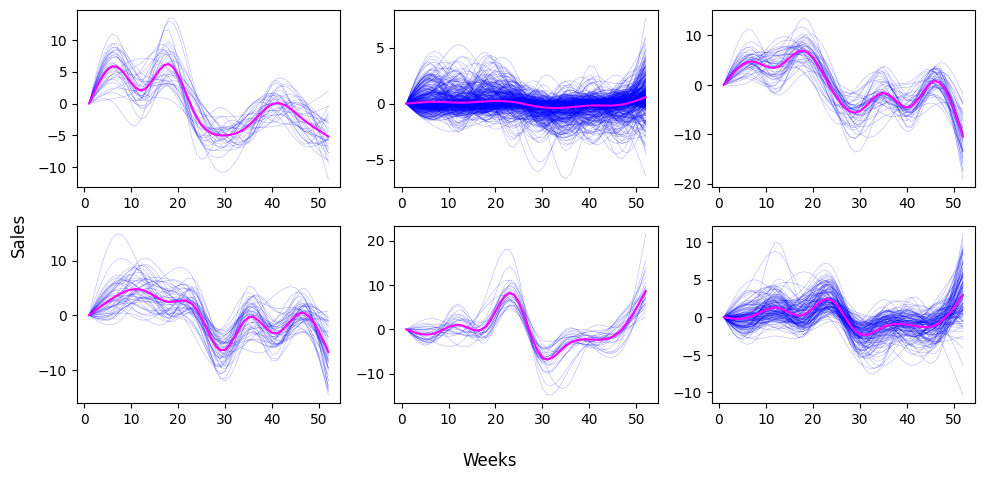

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=9539, n_init="auto").fit(B)

fig, axes = plt.subplots(nrows=2, ncols=3)
plot_lookup = {
    0: axes[0][0], 1: axes[0][1], 2: axes[0][2],
    3: axes[1][0], 4: axes[1][1], 5: axes[1][2],
}

for cluster in range(6):
    subplot = plot_lookup[cluster]
    cluster_coefficients, cluster_center = get_cluster(B, kmeans, cluster)
    for coefficients in cluster_coefficients:
        subplot.plot(week_idx, F.dot(coefficients), color='blue', alpha=0.3, linewidth=0.4)
    subplot.plot(week_idx, F.dot(cluster_center), color='fuchsia', linewidth=1.5)

fig.supxlabel("Weeks")
fig.supylabel("Sales")
fig.set_figwidth(10)
fig.tight_layout()

## Clustering Matrix X

Cluster 0: (3, 3)
Cluster 1: (624, 624)
Cluster 2: (36, 36)
Cluster 3: (18, 18)
Cluster 4: (73, 73)
Cluster 5: (57, 57)


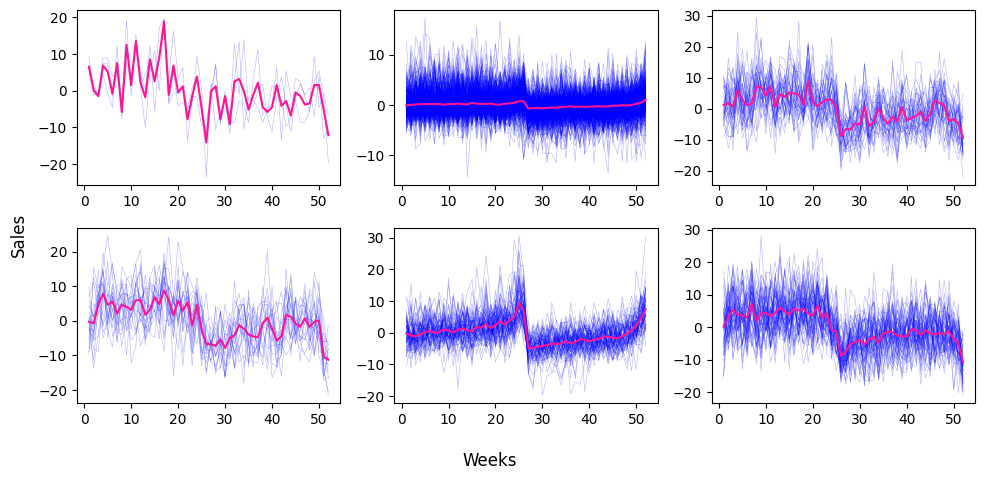

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=9539, n_init="auto").fit(X)

fig, axes = plt.subplots(nrows=2, ncols=3)
plot_lookup = {
    0: axes[0][0], 1: axes[0][1], 2: axes[0][2],
    3: axes[1][0], 4: axes[1][1], 5: axes[1][2],
}

for cluster in range(6):
    subplot = plot_lookup[cluster]
    cluster_sales, cluster_center = get_cluster(X, kmeans, cluster)
    for sales in cluster_sales:
        subplot.plot(week_idx, sales, color='blue', alpha=0.3, linewidth=0.4)
    subplot.plot(week_idx, cluster_center, color='deeppink', linewidth=1.5)

fig.supxlabel("Weeks")
fig.supylabel("Sales")
fig.set_figwidth(10)
fig.tight_layout()

# Part III: Ridgeless and Double Descent

In [ ]:
data = Coding3_dataH.to_numpy()
X, y = data[:, 1:], data[:, 0]

## Ridgeless Function

In [ ]:
def ridgeless(X_train, X_test, y_train, y_test):

    # default behavior of sklearn.decomposition.PCA is to center each column
    # of the design matrix from the training data without scaling
    pca = PCA().fit(X_train)
    F_train = pca.transform(X_train)
    k = sum(pca.singular_values_ > 1e-10)

    F_train = F_train[:, :k]
    F_test = pca.transform(X_test)[:, :k]

    B = y_train.T @ F_train / np.sum(F_train**2, axis=0)
    intercept = np.mean(y_train)

    train_mse = mean_squared_error(y_train, F_train.dot(B) + intercept)
    test_mse = mean_squared_error(y_test, F_test.dot(B) + intercept)
    return {"train_mse": train_mse, "test_mse": test_mse}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.75, random_state=9539
)
print(ridgeless(X_train, X_test, y_train, y_test))

{'train_mse': 2.736971693066806e-28, 'test_mse': 0.09933243245619897}


## Simulation Study

In [ ]:
test_errors = np.empty([30, 236], dtype=float) # 7080 simulations
print(test_errors.shape)
for i in range(30):
    for d in range(5, 241):
        X_train, X_test, y_train, y_test = train_test_split(
            X[:, :d], y, test_size=0.75, random_state=9539
        )
        test_error = ridgeless(X_train, X_test, y_train, y_test)
        test_errors[i, d-5] = test_error["test_mse"]
        # print(test_error)
    # print(f"iteration: {i+1}")

(30, 236)


Text(0, 0.5, 'Log of Test Error')

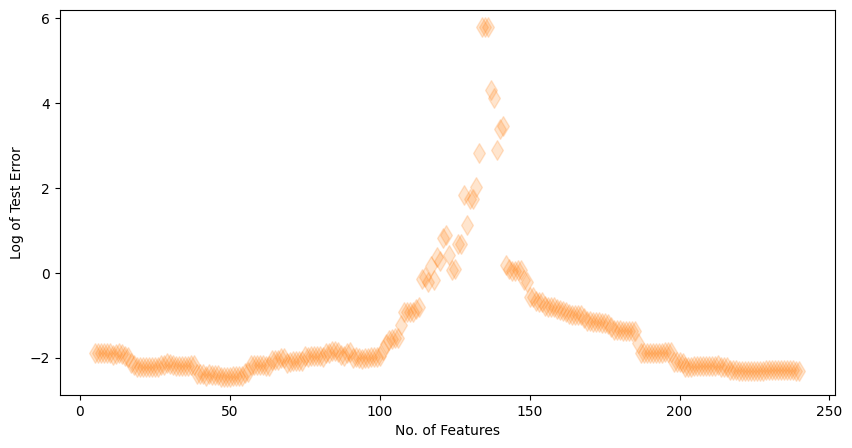

In [ ]:
plt.figure(figsize=(10,5))
x, y = range(5, 241), np.log(np.median(test_errors, axis=0))
plt.scatter(x, y, marker='d', s=100, linewidth=1, alpha=0.2, c='tab:orange')
# plt.plot(range(5, 241), np.log(np.median(test_errors, axis=0)))
plt.xlabel("No. of Features")
plt.ylabel("Log of Test Error")